In [1]:
# Import packages
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import datasets
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.stats import linregress
import time
import torchvision.utils

import importlib
import data
import helpers
import unet
import cloud_diffusion as cd

from helpers import fft
from helpers import ifft

from IPython.display import clear_output

In [2]:
# Uncomment and run these when making changes to .py files that require reloading modules
# Can also restart kernel, but this allows for reloading without running everything again
importlib.reload(data)
importlib.reload(helpers)
importlib.reload(unet)
importlib.reload(cd)

from helpers import fft
from helpers import ifft

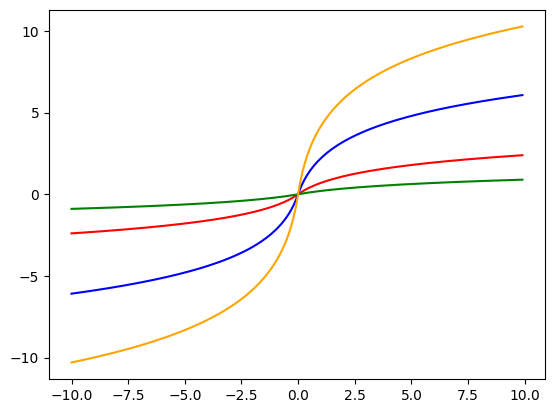

In [25]:
x = torch.arange(-10,10, step=.1)
slog1 = helpers.SymmetricLog(a=1)
slog2 = helpers.SymmetricLog(a=2)
slog3 = helpers.SymmetricLog(a=.5)
slog4 = helpers.SymmetricLog(a=3)

plt.plot(x,slog1(x), color="red", label="a=1")
plt.plot(x,slog2(x), color="blue", label="a=2")
plt.plot(x,slog3(x), color="green", label="a=.5")
plt.plot(x,slog4(x), color="orange", label="a=3")

plt.show()

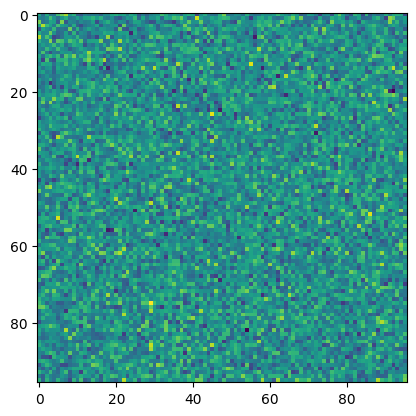

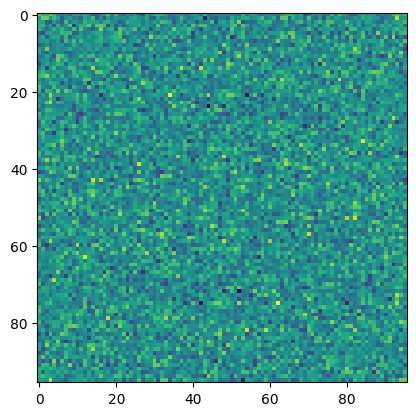

In [28]:
noise = torch.randn(96,96)
fft_noise = fft(noise)


plt.imshow(noise)
plt.show()

plt.imshow(fft_noise.real)
plt.show()

In [76]:
white_images_list = []
cloud_images_list = []
cloud2_images_list = []

for i in range(16):
    white_images = torch.load(f"Images/white_model/generated_tensor_{i+1}.pt")
    cloud_images = torch.load(f"Images/cloud_model/generated_tensor_{i+1}.pt")
    cloud2_images = torch.load(f"Images/cloud_model_2/generated_tensor_{i+1}.pt")
    
    white_images_list.append(white_images)
    cloud_images_list.append(cloud_images)
    cloud2_images_list.append(cloud2_images)

In [77]:
mu_white = torch.zeros(96,96, device="mps")
mu_cloud = torch.zeros(96,96, device="mps")
mu_cloud2 = torch.zeros(96,96, device="mps")

n=0

for i in range(16):
    _mu_white = white_images_list[i].squeeze().sum(dim=0)
    _mu_cloud = cloud_images_list[i].squeeze().sum(dim=0)
    _mu_cloud2 = cloud2_images_list[i].squeeze().sum(dim=0)
    
    mu_white = (mu_white*n + _mu_white)/(n+64)
    mu_cloud = (mu_cloud*n + _mu_cloud)/(n+64)
    mu_cloud2 = (mu_cloud2*n + _mu_cloud2)/(n+64)
    
    n+=64

In [84]:
sigma_white = torch.zeros(96,96,96,96, device="mps")
sigma_cloud = torch.zeros(96,96,96,96, device="mps")
sigma_cloud2 = torch.zeros(96,96,96,96, device="mps")

n=0

for i in range(16):
    white_images = white_images_list[i].squeeze()
    cloud_images = cloud_images_list[i].squeeze()
    cloud2_images = cloud2_images_list[i].squeeze()
    
    _sigma_white = torch.einsum("bij,bkl->ijkl", (white_images-mu_white), (white_images-mu_white))
    _sigma_cloud = torch.einsum("bij,bkl->ijkl", (cloud_images-mu_cloud), (cloud_images-mu_cloud))
    _sigma_cloud2 = torch.einsum("bij,bkl->ijkl", (cloud2_images-mu_cloud2), (cloud2_images-mu_cloud2))
    
    sigma_white = (sigma_white*n + _sigma_white)/(n+64)
    sigma_cloud = (sigma_cloud*n + _sigma_cloud)/(n+64)
    sigma_cloud2 = (sigma_cloud2*n + _sigma_cloud2)/(n+64)
    
    n+=64

In [137]:
noise_generator = helpers.NoiseGenerator(N=96)
noise_generator_95 = helpers.NoiseGenerator(N=95)
noise_generator_288 = helpers.NoiseGenerator(N=3*96)

In [138]:
Delta = 1.4999373536194076
A = 0.03419139414932271

In [147]:
mu_white_noise = torch.zeros(96,96, device="mps")
mu_cloud_noise = torch.zeros(96,96, device="mps")

n=0

for i in range(1000):
    _mu_white_noise = torch.randn(64,96,96, device="mps").sum(dim=0)
    _mu_cloud_noise = noise_generator_288.generate_noise_2(Delta=Delta,
                                                     A=A,
                                                     batch_size=64,
                                                     color_channels=1,
                                                     fft_norm="ortho",
                                                     device="mps")[0].real.squeeze().sum(dim=0)
    
    mu_white_noise = (mu_white_noise*n + _mu_white_noise)/(n+64)
    mu_cloud_noise = (mu_cloud_noise*n + _mu_cloud_noise)/(n+64)
    
    n+=64

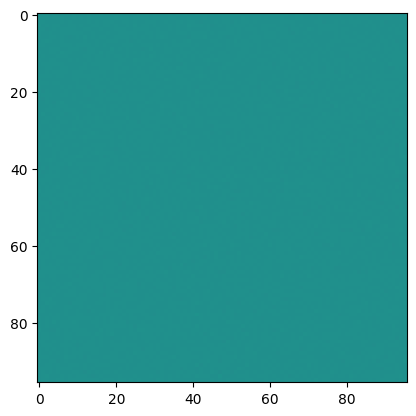

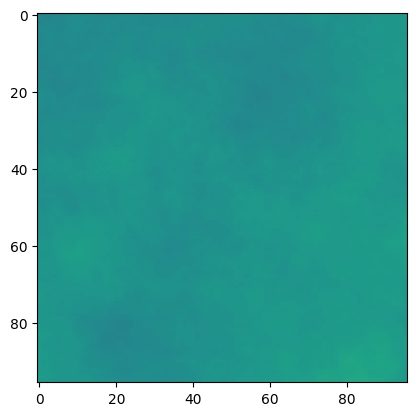

In [148]:
plt.imshow(mu_white_noise.to("cpu"), vmin=-1, vmax=1)
plt.show()

plt.imshow(mu_cloud_noise.to("cpu"), vmin=-.1, vmax=.1)
plt.show()

In [175]:
sigma_white_noise = torch.zeros(96,96,96,96, device="mps")
sigma_cloud_noise = torch.zeros(96,96,96,96, device="mps")

n=0

for i in range(10000):
    white_noise = torch.randn(64, 96, 96, device="mps")
    cloud_noise = noise_generator_288.generate_noise_2(Delta=Delta,
                                                     A=A,
                                                     batch_size=64,
                                                     color_channels=1,
                                                     fft_norm="ortho",
                                                     device="mps")[0].real.squeeze()
    
    
    _sigma_white_noise = torch.einsum("bij,bkl->ijkl", white_noise, white_noise)
    _sigma_cloud_noise = torch.einsum("bij,bkl->ijkl", cloud_noise, cloud_noise)
    
    sigma_white_noise = (sigma_white_noise*n + _sigma_white_noise)/(n+64)
    sigma_cloud_noise = (sigma_cloud_noise*n + _sigma_cloud_noise)/(n+64)
    
    n+=64

torch.Size([96, 96, 96, 96])


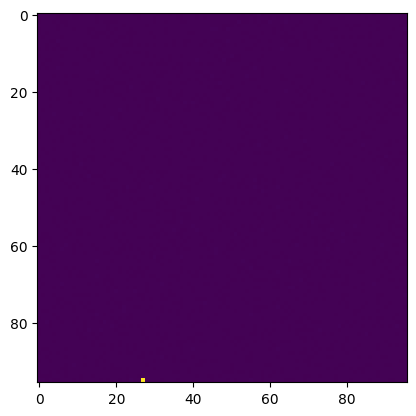

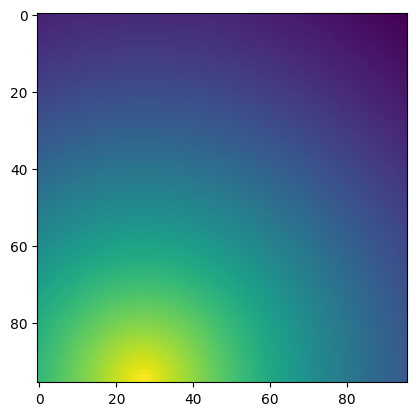

In [176]:
print(sigma_cloud_noise.shape)

i=95
j=27

plt.imshow(sigma_white_noise[i,j].to("cpu"))
plt.show()

plt.imshow(sigma_cloud_noise[i,j].to("cpu"))
plt.show()

In [155]:
sigma_white_noise_diag = torch.einsum("ijij->ij", sigma_white_noise)
sigma_cloud_noise_diag = torch.einsum("ijij->ij", sigma_cloud_noise)

In [159]:
print(sigma_cloud_noise_diag.min(), sigma_cloud_noise_diag.max())

tensor(2.9764, device='mps:0') tensor(3.0774, device='mps:0')


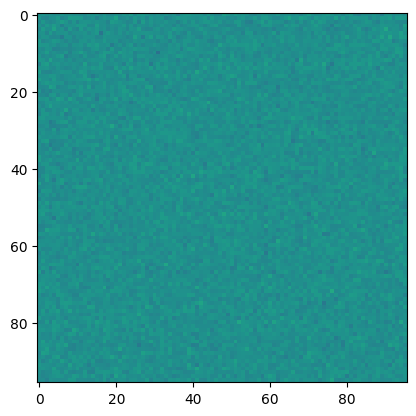

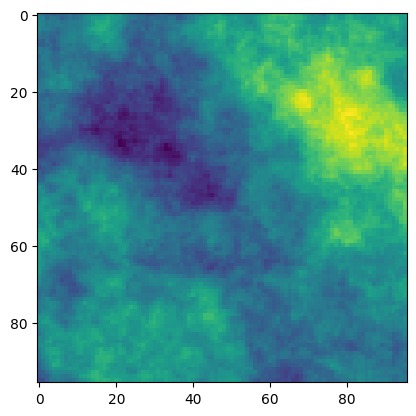

In [177]:
plt.imshow(sigma_white_noise_diag.to("cpu"), vmin=.9,vmax=1.1)
plt.show()

plt.imshow(sigma_cloud_noise_diag.to("cpu"))
plt.show()

In [178]:
sigma_cloud_noise_flat = torch.flatten(torch.flatten(sigma_cloud_noise, start_dim=0, end_dim=1), start_dim=1).to("cpu")

In [179]:
sigma_cloud_noise_flat_inv = torch.linalg.inv(sigma_cloud_noise_flat)

In [180]:
torch.einsum("ij,ji", sigma_cloud_noise_flat_inv, sigma_cloud_noise_flat)

tensor(9216.0146)

In [205]:
noise = torch.flatten(noise_generator_288.generate_noise_2(Delta=Delta,
                                                     A=A,
                                                     batch_size=64,
                                                     color_channels=1,
                                                     fft_norm="ortho",
                                                     device="cpu")[0][0].real.squeeze())
print(torch.einsum("i,ij,j", noise, sigma_cloud_noise_flat_inv, noise)-96*96)
print(torch.einsum("i,i", noise, noise))

tensor(115.1582)
tensor(21635.4473)


In [160]:
i=32
j=48

plt.imshow(mu_white.to("cpu"), vmin=-1, vmax=1)
plt.show()

plt.imshow(mu_cloud.to("cpu"), vmin=-1, vmax=1)
plt.show()

plt.imshow(mu_cloud2.to("cpu"), vmin=-1, vmax=1)
plt.show()

plt.imshow(sigma_white[i,j].to("cpu"), vmin=0, vmax=1)
plt.show()

plt.imshow(sigma_cloud[i,j].to("cpu"), vmin=0, vmax=1)
plt.show()

plt.imshow(sigma_cloud2[i,j].to("cpu"), vmin=0, vmax=1)
plt.show()

NameError: name 'mu_white' is not defined

In [277]:
N = 96
M=3*N
x = (torch.arange(M)-M//2).unsqueeze(-1).repeat((1,M))/(N-1)
y = (torch.arange(M)-M//2).unsqueeze(0).repeat((M,1))/(N-1)

In [276]:
print(x[M//2,3])
print(y[45,N]-y[45, 2*N-1])

tensor(0.)
tensor(-1.)


In [86]:
print(mu_white.mean())
print(mu_cloud.mean())
print(mu_cloud2.mean())

print(mu_white.std())
print(mu_cloud.std())
print(mu_cloud2.std())

tensor(0.0472, device='mps:0')
tensor(-0.3629, device='mps:0')
tensor(-0.1297, device='mps:0')
tensor(0.1084, device='mps:0')
tensor(0.0524, device='mps:0')
tensor(0.0839, device='mps:0')


In [87]:
sigma_diag_white = torch.einsum("ijij->ij", sigma_white)
sigma_diag_cloud = torch.einsum("ijij->ij", sigma_cloud)
sigma_diag_cloud2 = torch.einsum("ijij->ij", sigma_cloud2)

In [88]:
print(sigma_diag_white.mean())
print(sigma_diag_cloud.mean())
print(sigma_diag_cloud2.mean())

tensor(0.8418, device='mps:0')
tensor(1.4948, device='mps:0')
tensor(1.0973, device='mps:0')


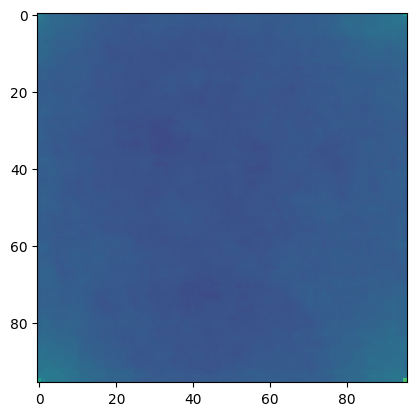

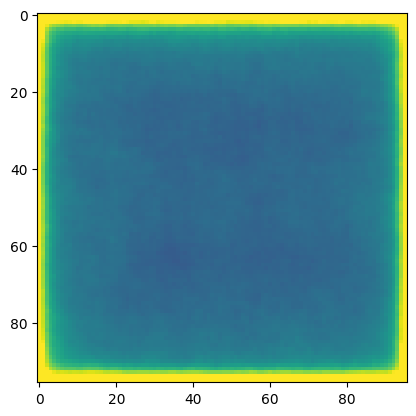

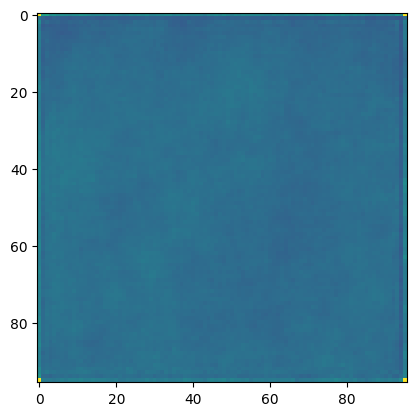

In [161]:
plt.imshow(sigma_diag_white.to("cpu"), vmin=0, vmax=3)
plt.show()

plt.imshow(sigma_diag_cloud.to("cpu"), vmin=0, vmax=3)
plt.show()

plt.imshow(sigma_diag_cloud2.to("cpu"), vmin=0, vmax=3)
plt.show()

In [91]:
def fid(mu1, sigma1, mu2, sigma2, device="mps"):
    mu_term = torch.einsum("ij,ij", (mu1-mu2), (mu1-mu2))
    sigma1_flat = torch.flatten(torch.flatten(sigma1, start_dim=0, end_dim=1), start_dim=1, end_dim=2)
    sigma2_flat = torch.flatten(torch.flatten(sigma2, start_dim=0, end_dim=1), start_dim=1, end_dim=2)
    
    tr_sigmas = torch.einsum("ii", sigma1_flat+sigma2_flat)
    sig_sig = torch.einsum("ik,kj->ij", sigma1_flat, sigma2_flat)
    eigs = torch.linalg.eigvals(sig_sig.to("cpu")).abs().to(device)
    sig_sig_term = -2*torch.sum(torch.sqrt(eigs))
    
    return (mu_term + tr_sigmas + sig_sig_term).item()

In [64]:
fid_white_cloud = fid(mu_white, sigma_white, mu_cloud, sigma_cloud)
print(fid_white_cloud)

3210.482421875


In [67]:
clean_dataset, dirty_dataset = data.get_datasets(batch_size=64)

Files already downloaded and verified
37157/100000 images (37.157%), moved to dirty dataset.
Clean list clipped to 62784 images so it is divisible by batch_size=64.


In [70]:
dataloader = torch.utils.data.DataLoader(clean_dataset, batch_size=64, shuffle=True, num_workers=4)

In [71]:
mu_clean, std_clean = helpers.get_mu_and_std(clean_dataset)
sigma_clean = helpers.get_sigma(dataloader, mu_clean, std_clean)

0/981 || Time Elapsed = 54.23462986946106
100/981 || Time Elapsed = 32.22579383850098
200/981 || Time Elapsed = 34.1084520816803
300/981 || Time Elapsed = 33.98575496673584
400/981 || Time Elapsed = 33.79027318954468
500/981 || Time Elapsed = 33.64181208610535
600/981 || Time Elapsed = 33.663854122161865
700/981 || Time Elapsed = 33.606372117996216
800/981 || Time Elapsed = 33.775129079818726
900/981 || Time Elapsed = 33.635820150375366


In [73]:
fid_clean_white = fid(mu_clean.to("mps"), sigma_clean.to("mps"), mu_white, sigma_white)
print(fid_clean_white)

1074.71484375


In [74]:
fid_clean_cloud = fid(mu_clean.to("mps"), sigma_clean.to("mps"), mu_cloud, sigma_cloud)
print(fid_clean_cloud)

5603.8671875


In [92]:
fid_clean_cloud2 = fid(mu_clean.to("mps"), sigma_clean.to("mps"), mu_cloud2, sigma_cloud2)
print(fid_clean_cloud2)

4697.46875


In [163]:
torch.slogdet(torch.flatten(torch.flatten(sigma_cloud2, start_dim=0, end_dim=1), start_dim=1, end_dim=2).to("cpu"))

torch.return_types.slogdet(
sign=tensor(-1.),
logabsdet=tensor(-101810.5469))

In [152]:
def KL_divergence(mu0, sigma0, mu1, sigma1, device="cpu"):
    
    mu1=mu1.to(device).squeeze()
    mu0=mu0.to(device).squeeze()
    
    sigma1 = torch.flatten(torch.flatten(sigma1.to(device), start_dim=0, end_dim=1), start_dim=1, end_dim=2)
    sigma0 = torch.flatten(torch.flatten(sigma0.to(device), start_dim=0, end_dim=1), start_dim=1, end_dim=2)
    
    sigma1_inv = torch.linalg.inv(sigma1)
    
    
    k = mu1.shape[0]*mu1.shape[1]
    
    sig_sig_term = torch.einsum("ij,ji", sigma1_inv, sigma0)
    print(torch.einsum("ik,kj->ij", sigma1_inv, sigma0))

    mu_term = torch.einsum("i,ij,j", torch.flatten(mu1-mu0), sigma1_inv, torch.flatten(mu1-mu0))
    
    log_term = torch.logdet(sigma1) - torch.logdet(sigma0)
    
    print("sig_sig_term", sig_sig_term)
    print("k", k)
    print("mu_term", mu_term)
    print("log_term", log_term)
    
    return 1/2 * (sig_sig_term - k + mu_term + log_term)
    

In [154]:
KL_clean_white = KL_divergence(mu_clean, sigma_clean, mu_clean, sigma_clean)
print(KL_clean_white)

tensor([[ 1.0002e+00,  1.6379e-04,  1.5990e-04,  ...,  3.2934e-05,
          2.9854e-05,  2.2214e-05],
        [-2.0185e-04,  9.9979e-01, -2.0970e-04,  ...,  1.3473e-05,
          2.7883e-05,  3.0226e-05],
        [ 1.1631e-05,  1.3563e-05,  1.0000e+00,  ..., -2.3515e-05,
         -2.9841e-05, -3.0843e-05],
        ...,
        [-8.8423e-05, -8.9913e-05, -9.0271e-05,  ...,  9.9995e-01,
         -2.5842e-05, -8.5516e-05],
        [ 4.4219e-05,  4.4131e-05,  4.5609e-05,  ...,  3.1211e-05,
          9.9995e-01,  1.2291e-05],
        [-5.0080e-05, -5.1946e-05, -5.2227e-05,  ..., -6.0132e-05,
         -1.5211e-05,  1.0000e+00]])
sig_sig_term tensor(9215.9082)
k 9216
mu_term tensor(0.)
log_term tensor(0.)
tensor(-0.0459)


In [137]:
KL_clean_cloud = KL_divergence(mu_cloud, sigma_cloud, mu_clean, sigma_clean)
print(KL_clean_cloud)

tensor(40230.8164)


In [138]:
KL_clean_cloud2 = KL_divergence(mu_cloud2, sigma_cloud2, mu_clean, sigma_clean)
print(KL_clean_cloud2)

tensor(nan)


In [359]:
noise_generator_96 = helpers.NoiseGenerator(N=96)

In [301]:
z, Z = noise_generator_96.generate_noise_2(Delta=Delta,
                                     A=A,
                                     batch_size=64,
                                     color_channels=1,
                                     fft_norm="ortho",
                                     device="mps"
                                     )

torch.Size([96, 96])


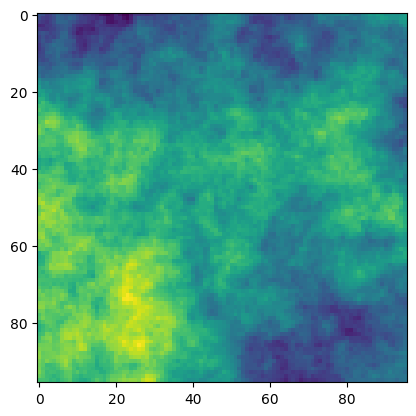

In [312]:
noise = z[32].imag.squeeze().to("cpu")
print(noise.shape)
plt.imshow(noise)
plt.show()

In [356]:
A = noise_generator_96.get_normalizing_A(Delta=Delta, n_batches=1000)

For N = 96, ∆ = 1.4999373536194076 to normalize position-space cloud noise to have std=1 use:
A = 0.10362764349930673


In [360]:
sigma_noise = noise_generator_96.get_sigma_noise(Delta=Delta, A=A, n_batches=1000, batch_size=64, device="mps")

In [361]:
sigma_noise_diag = torch.einsum("ijij->ij", sigma_noise)

In [362]:
print(sigma_noise_diag.min(), sigma_noise_diag.max(), sigma_noise_diag.std(), sigma_noise_diag.mean())

tensor(0.9777, device='mps:0') tensor(1.0040, device='mps:0') tensor(0.0037, device='mps:0') tensor(0.9936, device='mps:0')


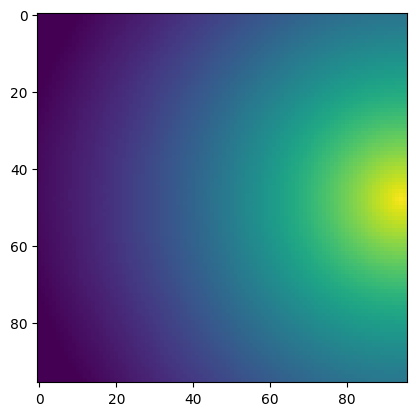

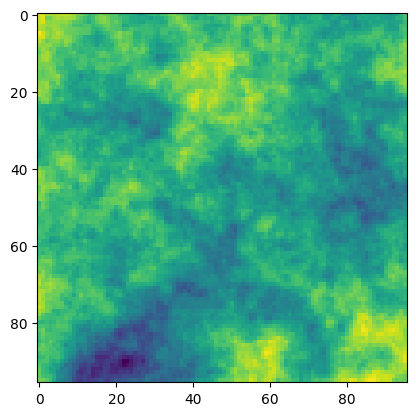

In [365]:
i=48
j=94
plt.imshow(sigma_noise[:,:,i,j].to("cpu"), vmin=0, vmax=1)
plt.show()

plt.imshow(sigma_noise_diag.to("cpu"))

# Color Analysis

In [18]:
def get_filter_lists(dataset, short_edge=1, long_edge=32, batch_size=64):
    """
    Builds two lists of integers representing the index of images in the dataset
      clean_list: indices of images with no letterboxes
      dirt_list: indices of images with letterboxes
    Clips the clean_list so that it is divisible by the batch size
    """
    horizontal_pool = torch.nn.AvgPool2d(kernel_size=(short_edge, long_edge), stride=(1, 1))
    vertical_pool = torch.nn.AvgPool2d(kernel_size=(long_edge, short_edge), stride=(1, 1))
    
    def has_vertical_bars(x):
        y = vertical_pool(x)
        if y.min() == 0.0 or y.max() == 1.0:
            return True
        else:
            return False
        
    def has_horizontal_bars(x):
        y = horizontal_pool(x)
        if y.min() == 0.0 or y.max() == 1.0:
            return True
        else:
            return False
    
    clean_list = []
    dirty_list = []
    
    for i in range(len(dataset)):
        image, _ = dataset[i]
        
        if has_vertical_bars(image) or has_horizontal_bars(image):
            dirty_list.append(i)
        else:
            clean_list.append(i)
    
    c = len(clean_list)
    d = len(dirty_list)
    
    print(f"{d}/{c+d} images ({100 * d/(d+c)}%), moved to dirty dataset.")
    
    clean_list = clean_list[0:c//batch_size * batch_size]
    
    print(f"Clean list clipped to {len(clean_list)} images so it is divisible by batch_size={batch_size}.")
    
    return clean_list, dirty_list

In [6]:
def get_datasets(batch_size=64):
    
    # Applies minimal transformations to STL10 data
    # Preserves 96x96 size but converts to grayscale
    minimal_transforms = transforms.Compose([transforms.ToTensor()])
    
    base_dataset = datasets.STL10(root='data', download=True, transform=minimal_transforms, split="unlabeled")
    clean_list, dirty_list = get_filter_lists(base_dataset, batch_size=batch_size)
    
    clean_dataset = torch.utils.data.Subset(base_dataset, clean_list)
    dirty_dataset = torch.utils.data.Subset(base_dataset, dirty_list)
    
    return clean_dataset, dirty_dataset

In [7]:
clean_dataset = get_datasets(batch_size=64)[0]

Files already downloaded and verified
37886/100000 images (37.886%), moved to dirty dataset.
Clean list clipped to 62080 images so it is divisible by batch_size=64.


In [98]:
dataloader = torch.utils.data.DataLoader(clean_dataset, batch_size=64, shuffle=True, num_workers=4)

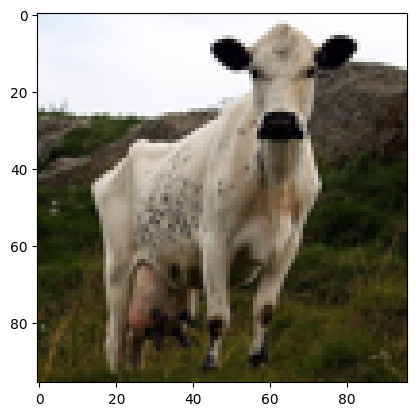

In [97]:
n = np.random.randint(len(clean_dataset))
plt.imshow(torch.movedim(clean_dataset[n][0], (0,1,2), (2,0,1)))

In [109]:
mu = torch.zeros(3, 96, 96, device="mps")
data_iter = iter(dataloader)

n=0
for i in range(len(data_iter)):
    image = next(data_iter)[0].to("mps")
    _mu = image.sum(dim=0)
    mu = (mu*n + _mu)/(n+64)
    n+=64
    if i%50 == 0:
        clear_output()
        print(f"{i}/{len(data_iter)}")

950/970


In [111]:
mu.max()

tensor(0.4909, device='mps:0')

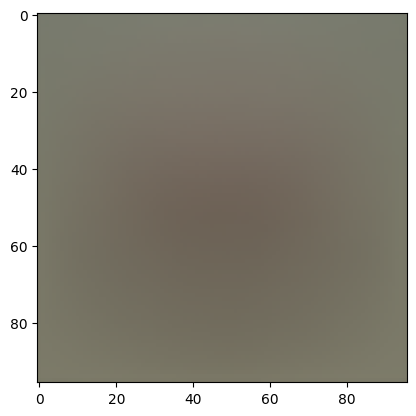

In [114]:
plt.imshow(torch.movedim(mu.to("cpu"), (0,1,2), (2,0,1)), vmin=0, vmax=1)

In [119]:
data_iter = iter(dataloader)
d=4
D = 96//d
avgpool = torch.nn.AvgPool2d(kernel_size=d, stride=d)
sigma = torch.zeros(3,D,D,3,D,D, device="mps")
mu_small = avgpool(mu)
n=0
for i in range(len(data_iter)):
    x = avgpool(next(data_iter)[0].to("mps"))
    _sigma = torch.einsum("bcij,bCKL->cijCKL", (x-mu_small), (x-mu_small))
    sigma = (sigma*n + _sigma)/(n+64)
    n+=64
    
    if i%50 == 0:
        clear_output()
        print(f"{i}/{len(data_iter)}")

950/970


In [148]:
sigma_diag = torch.einsum("cijCij->Ccij", sigma)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 24, 24])
tensor(0.0553, device='mps:0')
tensor(-0.0042, device='mps:0')


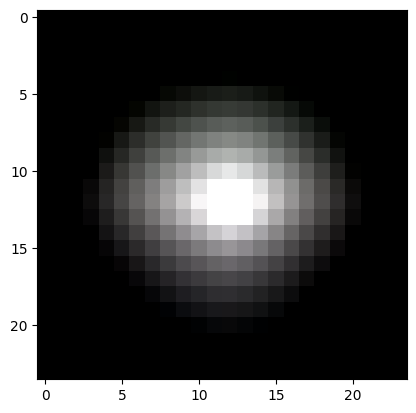

In [248]:
C=0
K=12
L=12

sig=sigma[:,:,:,C,K,L].to("cpu")
sig_normalized = (sig-sig.mean(dim=(-2,-1), keepdim=True))/sig.std(dim=(-2,-1), keepdim=True)/3

print(sig.shape)
print(sigma[...,C,K,L].max())
print(sigma[...,C,K,L].min())
plt.imshow(torch.movedim(sig_normalized, (0,1,2), (2,0,1)))
plt.show()

In [187]:
torch.mean(sigma_diag.to("cpu"), dim=(-2,-1))

tensor([[0.0516, 0.0450, 0.0397],
        [0.0450, 0.0474, 0.0441],
        [0.0397, 0.0441, 0.0515]])

In [179]:
L, V = torch.linalg.eig(torch.mean(sigma_diag.to("cpu"), dim=(-2,-1)))
print(L.real)
print(V.real)

tensor([0.1360, 0.0119, 0.0026])
tensor([[-0.5786, -0.6824,  0.4468],
        [-0.5794, -0.0417, -0.8140],
        [-0.5741,  0.7298,  0.3712]])


In [194]:
r = torch.zeros(3,1,1)
g = torch.zeros(3,1,1)
b = torch.zeros(3,1,1)

r[0]=1
g[1]=1
b[2]=1

print(r.shape)

torch.Size([3, 1, 1])


In [207]:
C1 = 0.5786*r + 0.6824*b - 0.4468*g + mu_small.to("cpu").mean(dim=(-2,-1), keepdim=True)
C2 = 0.5794*r + 0.0417*b + 0.8140*g + mu_small.to("cpu").mean(dim=(-2,-1), keepdim=True)
C3 = -0.5741*r + 0.7298*b + 0.3712*g + mu_small.to("cpu").mean(dim=(-2,-1), keepdim=True)

In [213]:
print(C1)
print(C2)
print(C3)

tensor([[[1.0429e+00]],

        [[1.6236e-04]],

        [[1.0756e+00]]])
tensor([[[1.0437]],

        [[1.2610]],

        [[0.4349]]])
tensor([[[-0.1098]],

        [[ 0.8182]],

        [[ 1.1230]]])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


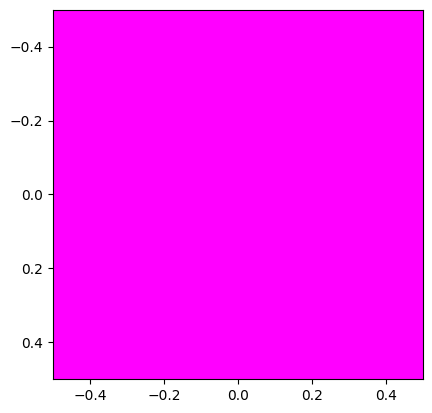

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


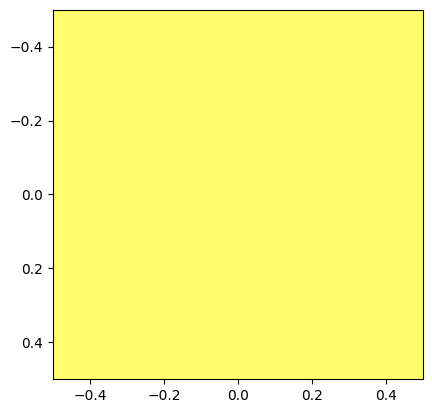

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


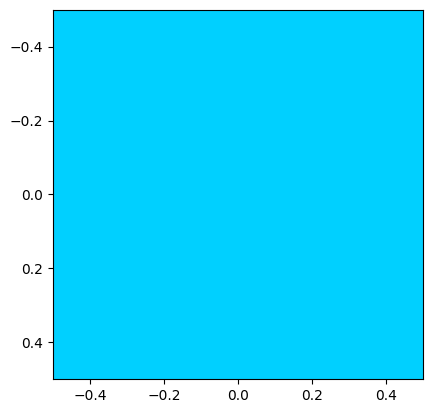

In [208]:
plt.imshow(torch.movedim(C1, (0,1,2), (2,0,1)))
plt.show()

plt.imshow(torch.movedim(C2, (0,1,2), (2,0,1)))
plt.show()

plt.imshow(torch.movedim(C3, (0,1,2), (2,0,1)))
plt.show()

In [211]:
print(C3)

tensor([[[-0.1098]],

        [[ 0.8182]],

        [[ 1.1230]]])


In [ ]:
mu = torch.zeros(3, 96, 96, device="mps")
data_iter = iter(dataloader)

n=0
for i in range(len(data_iter)):
    image = next(data_iter)[0].to("mps")
    _mu = image.sum(dim=0)
    mu = (mu*n + _mu)/(n+64)
    n+=64
    if i%50 == 0:
        clear_output()
        print(f"{i}/{len(data_iter)}")

# New Calculation of FID

In [19]:
def get_datasets(batch_size=64):
    
    # Applies minimal transformations to STL10 data
    # Preserves 96x96 size but converts to grayscale
    minimal_transforms = transforms.Compose([transforms.Grayscale(), transforms.ToTensor()])
    
    base_dataset = datasets.STL10(root='data', download=True, transform=minimal_transforms, split="unlabeled")
    clean_list, dirty_list = get_filter_lists(base_dataset, batch_size=batch_size)
    
    clean_dataset = torch.utils.data.Subset(base_dataset, clean_list)
    dirty_dataset = torch.utils.data.Subset(base_dataset, dirty_list)
    
    return clean_dataset, dirty_dataset

In [20]:
clean_dataset = get_datasets()[0]

Files already downloaded and verified
37157/100000 images (37.157%), moved to dirty dataset.
Clean list clipped to 62784 images so it is divisible by batch_size=64.


In [21]:
dataloader = torch.utils.data.DataLoader(clean_dataset, batch_size=64, shuffle=True, num_workers=4)

In [33]:
mu_clean, std_clean = helpers.get_mu_and_std(clean_dataset)

In [ ]:
data_iter = iter(dataloader)
sigma_clean = torch.zeros(96,96,96,96, device="mps")
n=0

for i in range(len(data_iter)):
    batch_clean = next(data_iter)[0].squeeze().to("mps")
    
    _sigma_clean = torch.einsum("bij,bkl->ijkl", batch_clean-mu_clean, batch_clean-mu_clean)
    sigma_clean = (sigma_clean*n + _sigma_clean)/(n+64)
    
    n+=64

In [35]:
def denormalize(x, device="mps"):
    return x*std_clean.to("mps") + mu_clean.to("mps")

In [36]:
mu_white = torch.zeros(96,96, device="mps")
mu_cloud = torch.zeros(96,96, device="mps")
n=0

for i in range(1,101):
    batch_white = denormalize(torch.load(f"Images/new_white_model/generated_tensor_{i}.pt").squeeze().to("mps"))
    batch_cloud = denormalize(torch.load(f"Images/new_cloud_model_5/generated_tensor_{i}.pt").squeeze().to("mps"))
    
    _mu_white = batch_white.sum(dim=0, keepdim=False)
    _mu_cloud = batch_cloud.sum(dim=0, keepdim=False)
    
    mu_white = (mu_white*n + _mu_white)/(n+64)
    mu_cloud = (mu_cloud*n + _mu_cloud)/(n+64)
    
    n+=64

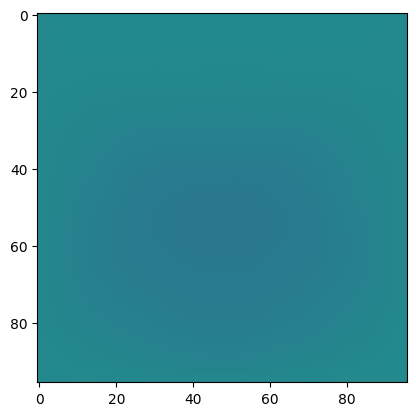

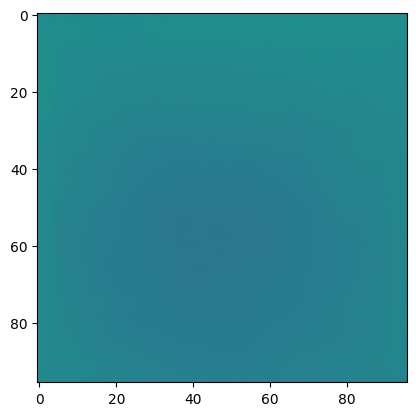

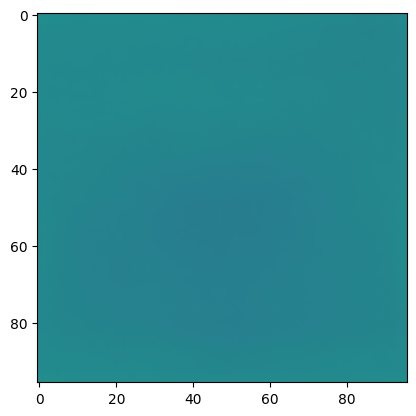

In [37]:
plt.imshow(mu_clean.to("cpu"), vmin=0, vmax=1)
plt.show()
plt.imshow(mu_white.to("cpu"), vmin=0, vmax=1)
plt.show()
plt.imshow(mu_cloud.to("cpu"), vmin=0, vmax=1)
plt.show()

In [38]:
sigma_white = torch.zeros(96,96,96,96, device="mps")
sigma_cloud = torch.zeros(96,96,96,96, device="mps")
n=0

for i in range(1,101):
    batch_white = torch.load(f"Images/new_white_model/generated_tensor_{i}.pt").squeeze().to("mps")
    batch_cloud = torch.load(f"Images/new_cloud_model_5/generated_tensor_{i}.pt").squeeze().to("mps")
    
    _sigma_white = torch.einsum("bij,bkl->ijkl", batch_white-mu_white, batch_white-mu_white)
    _sigma_cloud = torch.einsum("bij,bkl->ijkl", batch_cloud-mu_cloud, batch_cloud-mu_cloud)
    
    sigma_white = (sigma_white*n + _sigma_white)/(n+64)
    sigma_cloud = (sigma_cloud*n + _sigma_cloud)/(n+64)
    
    n+=64

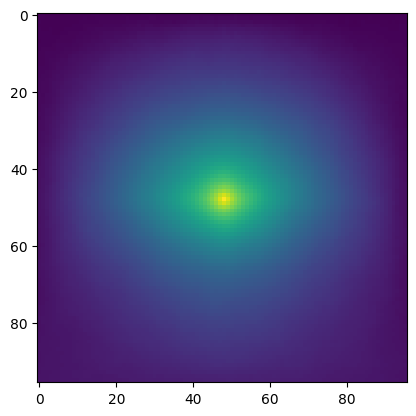

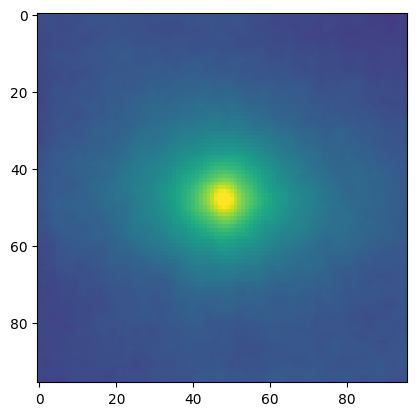

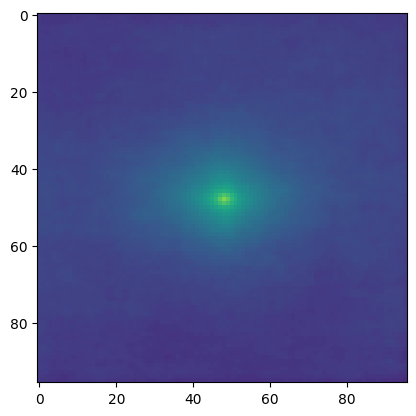

In [40]:
k=48
l=48

plt.imshow(sigma_clean[:,:,k,l].to("cpu"))
plt.show()

plt.imshow(sigma_white[:,:,k,l].to("cpu"), vmin=0, vmax=1)
plt.show()

plt.imshow(sigma_cloud[:,:,k,l].to("cpu"), vmin=0, vmax=1)
plt.show()